## Imports & Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import copy
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Data Loading & Preprocessing

In [4]:
# Data Loading and Preprocessing
def load_cifar10(batch_size=128):
    # Data transformations
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    # Load datasets
    train_dataset = datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )

    test_dataset = datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    return train_loader, test_loader


## Model Definitions

### Model 1: Basic CNN

In [5]:
class BasicCNN(nn.Module):
    def __init__(self, activation='relu', dropout=0, batch_norm=False):
        super(BasicCNN, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if batch_norm else None
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) if batch_norm else None
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) if batch_norm else None
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc_bn = nn.BatchNorm1d(512) if batch_norm else None
        self.fc2 = nn.Linear(512, 10)

        # Dropout
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None

        # Activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1)
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError(f"Activation {activation} not supported")

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        if self.bn1:
            x = self.bn1(x)
        x = self.activation(x)
        x = self.pool1(x)

        # Layer 2
        x = self.conv2(x)
        if self.bn2:
            x = self.bn2(x)
        x = self.activation(x)
        x = self.pool2(x)

        # Layer 3
        x = self.conv3(x)
        if self.bn3:
            x = self.bn3(x)
        x = self.activation(x)
        x = self.pool3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        if self.fc_bn:
            x = self.fc_bn(x)
        x = self.activation(x)
        if self.dropout:
            x = self.dropout(x)
        x = self.fc2(x)

        return x

### Model 2: Simplified VGG11 for CIFAR-10

In [6]:
class VGG11(nn.Module):
    def __init__(self, activation='relu', dropout=0, batch_norm=False):
        super(VGG11, self).__init__()

        # Save parameters for use in forward pass
        self.activation_name = activation
        self.dropout_rate = dropout

        # Each tuple is (in_channels, out_channels, kernel_size, padding)
        self.config = [
            (3, 64, 3, 1),
            (64, 128, 3, 1),
            (128, 256, 3, 1),
            (256, 256, 3, 1),
            (256, 512, 3, 1),
            (512, 512, 3, 1),
            (512, 512, 3, 1),
            (512, 512, 3, 1),
        ]

        # Build feature layers
        self.features = self._make_layers(batch_norm)

        # Will determine the classifier size dynamically in the first forward pass
        self.classifier = None
        self.feature_size = None

    def _get_activation(self, activation):
        if activation == 'relu':
            return nn.ReLU(inplace=True)
        elif activation == 'leaky_relu':
            return nn.LeakyReLU(0.1, inplace=True)
        elif activation == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Activation {activation} not supported")

    def _make_layers(self, batch_norm):
        layers = []
        for i, (in_channels, out_channels, kernel_size, padding) in enumerate(self.config):
            # Add convolutional layer
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))

            # Add batch normalization if specified
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))

            # Add activation function
            layers.append(self._get_activation(self.activation_name))

            # Add max pooling after every second conv layer (or if it's the last layer)
            if (i % 2 == 1) or (i == len(self.config) - 1):
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)

        # Initialize classifier on first forward pass to ensure correct dimensions
        if self.classifier is None:
            self.feature_size = x.size(1) * x.size(2) * x.size(3)
            self.classifier = nn.Sequential(
                nn.Linear(self.feature_size, 512),
                self._get_activation(self.activation_name),
                nn.Dropout(self.dropout_rate) if self.dropout_rate > 0 else nn.Identity(),
                nn.Linear(512, 10)
            )
            # Move classifier to the same device as input tensor
            self.classifier = self.classifier.to(x.device)

        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Training & Evaluation Functions

In [7]:
def train_model(model, train_loader, optimizer, criterion, device, epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track stats
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate epoch stats
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        # Save stats
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    return train_losses, train_accuracies

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track stats
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate final stats
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    return test_loss, test_acc

# Hyperparameter Tuning Framework
def hyperparameter_tuning(model_class, train_loader, test_loader, device, epochs=10):
    # Define hyperparameters to tune
    activations = ['relu', 'leaky_relu', 'sigmoid']
    regularizations = [
        {'dropout': 0, 'batch_norm': False},
        {'dropout': 0.5, 'batch_norm': False},
        {'dropout': 0.5, 'batch_norm': True}
    ]
    optimizers = ['sgd', 'adam']

    # Results storage
    results = []

    # Criterion for all models
    criterion = nn.CrossEntropyLoss()

    # Create and train each model configuration
    for activation in activations:
        for reg in regularizations:
            for opt_name in optimizers:
                # Create model
                model = model_class(
                    activation=activation,
                    dropout=reg['dropout'],
                    batch_norm=reg['batch_norm']
                ).to(device)

                # Configure optimizer
                if opt_name == 'sgd':
                    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
                else:  # adam
                    optimizer = optim.Adam(model.parameters(), lr=0.001)

                # Create a unique model name
                model_name = f"{model_class.__name__}_{activation}_{opt_name}"
                if reg['dropout'] > 0:
                    model_name += f"_dropout{reg['dropout']}"
                if reg['batch_norm']:
                    model_name += "_batchnorm"

                print(f"\nTraining model: {model_name}")
                start_time = time.time()

                # Train model
                train_losses, train_accuracies = train_model(
                    model, train_loader, optimizer, criterion, device, epochs=epochs
                )

                # Evaluate model
                test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

                training_time = time.time() - start_time

                # Save results
                results.append({
                    'model_name': model_name,
                    'model_class': model_class.__name__,
                    'activation': activation,
                    'dropout': reg['dropout'],
                    'batch_norm': reg['batch_norm'],
                    'optimizer': opt_name,
                    'train_losses': train_losses,
                    'train_accuracies': train_accuracies,
                    'test_loss': test_loss,
                    'test_accuracy': test_acc,
                    'training_time': training_time,
                    'model': copy.deepcopy(model)
                })

                print(f"Completed {model_name} in {training_time:.2f} seconds")

    return results


## Visualization Functions

In [8]:
def plot_learning_curves(results, model_class_name):
    """Plot learning curves for all models of a specific class"""
    # Filter results by model class
    class_results = [r for r in results if r['model_class'] == model_class_name]

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Training loss curves
    for result in class_results:
        ax1.plot(result['train_losses'], label=result['model_name'])

    ax1.set_title(f'Training Loss - {model_class_name}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Training accuracy curves
    for result in class_results:
        ax2.plot(result['train_accuracies'], label=result['model_name'])

    ax2.set_title(f'Training Accuracy - {model_class_name}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_test_accuracy_comparison(results):
    """Plot test accuracy comparison for all models"""
    # Extract model names and test accuracies
    model_names = [r['model_name'] for r in results]
    test_accuracies = [r['test_accuracy'] for r in results]

    # Create a dataframe for easier plotting
    df = pd.DataFrame({
        'Model': model_names,
        'Test Accuracy': test_accuracies
    })

    # Sort by accuracy
    df = df.sort_values('Test Accuracy', ascending=False)

    # Plot
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Test Accuracy', y='Model', data=df)

    # Add values to bars
    for i, v in enumerate(df['Test Accuracy']):
        ax.text(v + 0.01, i, f"{v:.4f}", va='center')

    plt.title('Test Accuracy Comparison')
    plt.tight_layout()
    plt.show()

def plot_hyperparameter_heatmap(results, model_class_name):
    """Create a heatmap showing the effect of hyperparameters on accuracy"""
    # Filter results by model class
    class_results = [r for r in results if r['model_class'] == model_class_name]

    # Extract unique hyperparameter values
    activations = sorted(set(r['activation'] for r in class_results))
    optimizers = sorted(set(r['optimizer'] for r in class_results))

    # Create a dataframe for heatmaps
    rows = []
    for r in class_results:
        reg_type = "None"
        if r['batch_norm'] and r['dropout'] > 0:
            reg_type = "Dropout + BatchNorm"
        elif r['dropout'] > 0:
            reg_type = "Dropout"

        rows.append({
            'Activation': r['activation'],
            'Optimizer': r['optimizer'],
            'Regularization': reg_type,
            'Accuracy': r['test_accuracy']
        })

    df = pd.DataFrame(rows)

    # Create a pivot table for the heatmap
    pivot = df.pivot_table(
        index='Regularization',
        columns=['Activation', 'Optimizer'],
        values='Accuracy'
    )

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".4f")
    plt.title(f'Hyperparameter Heatmap - {model_class_name}')
    plt.tight_layout()
    plt.show()

def plot_training_time_comparison(results):
    """Plot training time comparison for all models"""
    # Extract model names and training times
    model_names = [r['model_name'] for r in results]
    training_times = [r['training_time'] for r in results]

    # Create a dataframe for easier plotting
    df = pd.DataFrame({
        'Model': model_names,
        'Training Time (s)': training_times
    })

    # Sort by training time
    df = df.sort_values('Training Time (s)')

    # Plot
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Training Time (s)', y='Model', data=df)

    # Add values to bars
    for i, v in enumerate(df['Training Time (s)']):
        ax.text(v + 0.5, i, f"{v:.2f}s", va='center')

    plt.title('Training Time Comparison')
    plt.tight_layout()
    plt.show()

def plot_model_comparison(results):
    """Compare best models from each architecture class"""
    # Find best model for each class
    best_models = {}
    for model_class in set(r['model_class'] for r in results):
        class_results = [r for r in results if r['model_class'] == model_class]
        best_model = max(class_results, key=lambda x: x['test_accuracy'])
        best_models[model_class] = best_model

    # Extract data for comparison
    model_classes = list(best_models.keys())
    test_accuracies = [best_models[mc]['test_accuracy'] for mc in model_classes]
    training_times = [best_models[mc]['training_time'] for mc in model_classes]

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Test accuracy comparison
    ax1.bar(model_classes, test_accuracies, color=['skyblue', 'salmon'])
    for i, v in enumerate(test_accuracies):
        ax1.text(i, v + 0.01, f"{v:.4f}", ha='center')
    ax1.set_title('Best Test Accuracy Comparison')
    ax1.set_ylim(0, 1.0)

    # Training time comparison
    ax2.bar(model_classes, training_times, color=['skyblue', 'salmon'])
    for i, v in enumerate(training_times):
        ax2.text(i, v + 5, f"{v:.2f}s", ha='center')
    ax2.set_title('Training Time Comparison')

    plt.tight_layout()
    plt.show()

    # Print details of best models
    print("Best Models Details:")
    for model_class, model_data in best_models.items():
        print(f"\n{model_class}:")
        print(f"  Configuration: {model_data['model_name']}")
        print(f"  Test Accuracy: {model_data['test_accuracy']:.4f}")
        print(f"  Training Time: {model_data['training_time']:.2f} seconds")

## Main Execution


=== Part 1: Hyperparameter Search for BasicCNN ===

Training model: BasicCNN_relu_sgd


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.8327, Accuracy: 0.3224


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.4235, Accuracy: 0.4828


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.2237, Accuracy: 0.5583


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.0640, Accuracy: 0.6220


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.9435, Accuracy: 0.6700


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.8609, Accuracy: 0.6977


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.8019, Accuracy: 0.7199


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.7556, Accuracy: 0.7374


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.7118, Accuracy: 0.7506


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.6717, Accuracy: 0.7661


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.6610, Test Accuracy: 0.7715
Completed BasicCNN_relu_sgd in 195.03 seconds

Training model: BasicCNN_relu_adam


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.5462, Accuracy: 0.4321


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.1508, Accuracy: 0.5884


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.9705, Accuracy: 0.6551


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.8643, Accuracy: 0.6954


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.7876, Accuracy: 0.7220


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.7321, Accuracy: 0.7432


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.6868, Accuracy: 0.7594


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.6492, Accuracy: 0.7714


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.6180, Accuracy: 0.7836


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.5901, Accuracy: 0.7940


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.6051, Test Accuracy: 0.7938
Completed BasicCNN_relu_adam in 188.86 seconds

Training model: BasicCNN_relu_sgd_dropout0.5


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.8858, Accuracy: 0.3004


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.5071, Accuracy: 0.4479


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.3247, Accuracy: 0.5177


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.1703, Accuracy: 0.5802


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.0516, Accuracy: 0.6266


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.9668, Accuracy: 0.6583


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.9017, Accuracy: 0.6824


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.8453, Accuracy: 0.7021


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.8172, Accuracy: 0.7125


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.7782, Accuracy: 0.7294


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.6709, Test Accuracy: 0.7714
Completed BasicCNN_relu_sgd_dropout0.5 in 191.95 seconds

Training model: BasicCNN_relu_adam_dropout0.5


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.6198, Accuracy: 0.4054


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.2673, Accuracy: 0.5444


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.0921, Accuracy: 0.6130


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.9831, Accuracy: 0.6523


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.9078, Accuracy: 0.6845


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.8460, Accuracy: 0.7042


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.8029, Accuracy: 0.7191


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.7791, Accuracy: 0.7295


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.7373, Accuracy: 0.7418


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.7177, Accuracy: 0.7499


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.6913, Test Accuracy: 0.7599
Completed BasicCNN_relu_adam_dropout0.5 in 197.75 seconds

Training model: BasicCNN_relu_sgd_dropout0.5_batchnorm


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.4309, Accuracy: 0.4795


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.1103, Accuracy: 0.6018


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.9927, Accuracy: 0.6478


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.9029, Accuracy: 0.6792


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.8466, Accuracy: 0.6995


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.8021, Accuracy: 0.7165


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.7722, Accuracy: 0.7286


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.7371, Accuracy: 0.7397


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.7123, Accuracy: 0.7483


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.6887, Accuracy: 0.7590


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.6203, Test Accuracy: 0.7822
Completed BasicCNN_relu_sgd_dropout0.5_batchnorm in 196.87 seconds

Training model: BasicCNN_relu_adam_dropout0.5_batchnorm


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.3509, Accuracy: 0.5102


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.0124, Accuracy: 0.6403


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.8869, Accuracy: 0.6902


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.8155, Accuracy: 0.7137


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.7628, Accuracy: 0.7346


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.7268, Accuracy: 0.7453


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.6834, Accuracy: 0.7622


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.6651, Accuracy: 0.7678


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.6340, Accuracy: 0.7814


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.6121, Accuracy: 0.7862


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.5568, Test Accuracy: 0.8041
Completed BasicCNN_relu_adam_dropout0.5_batchnorm in 194.31 seconds

Training model: BasicCNN_leaky_relu_sgd


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.8313, Accuracy: 0.3248


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.4079, Accuracy: 0.4896


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.2085, Accuracy: 0.5665


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.0601, Accuracy: 0.6245


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.9627, Accuracy: 0.6618


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.8706, Accuracy: 0.6949


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.8071, Accuracy: 0.7173


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.7486, Accuracy: 0.7362


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.7072, Accuracy: 0.7539


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.6748, Accuracy: 0.7636


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.6801, Test Accuracy: 0.7643
Completed BasicCNN_leaky_relu_sgd in 196.11 seconds

Training model: BasicCNN_leaky_relu_adam


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.5004, Accuracy: 0.4513


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.0698, Accuracy: 0.6179


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.8897, Accuracy: 0.6862


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.7805, Accuracy: 0.7248


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.7162, Accuracy: 0.7484


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.6616, Accuracy: 0.7665


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.6192, Accuracy: 0.7831


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.5893, Accuracy: 0.7928


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.5621, Accuracy: 0.8028


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.5315, Accuracy: 0.8135


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.5821, Test Accuracy: 0.8025
Completed BasicCNN_leaky_relu_adam in 198.59 seconds

Training model: BasicCNN_leaky_relu_sgd_dropout0.5


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.8805, Accuracy: 0.3064


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.4844, Accuracy: 0.4564


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.3082, Accuracy: 0.5258


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.1638, Accuracy: 0.5837


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.0477, Accuracy: 0.6283


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.9617, Accuracy: 0.6613


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.9028, Accuracy: 0.6814


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.8451, Accuracy: 0.7041


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.8043, Accuracy: 0.7197


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.7662, Accuracy: 0.7327


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.7010, Test Accuracy: 0.7573
Completed BasicCNN_leaky_relu_sgd_dropout0.5 in 196.36 seconds

Training model: BasicCNN_leaky_relu_adam_dropout0.5


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.5248, Accuracy: 0.4440


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.1082, Accuracy: 0.6060


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.9435, Accuracy: 0.6675


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.8549, Accuracy: 0.7006


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.7925, Accuracy: 0.7208


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.7402, Accuracy: 0.7411


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.7064, Accuracy: 0.7527


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.6797, Accuracy: 0.7621


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.6511, Accuracy: 0.7722


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.6321, Accuracy: 0.7812


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.5735, Test Accuracy: 0.7979
Completed BasicCNN_leaky_relu_adam_dropout0.5 in 199.29 seconds

Training model: BasicCNN_leaky_relu_sgd_dropout0.5_batchnorm


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.4329, Accuracy: 0.4803


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.1131, Accuracy: 0.6010


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.9835, Accuracy: 0.6532


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.9172, Accuracy: 0.6749


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.8580, Accuracy: 0.6959


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.8115, Accuracy: 0.7145


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.7793, Accuracy: 0.7258


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.7569, Accuracy: 0.7345


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.7162, Accuracy: 0.7501


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.7024, Accuracy: 0.7541


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.6235, Test Accuracy: 0.7825
Completed BasicCNN_leaky_relu_sgd_dropout0.5_batchnorm in 204.78 seconds

Training model: BasicCNN_leaky_relu_adam_dropout0.5_batchnorm


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.3354, Accuracy: 0.5190


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.0101, Accuracy: 0.6431


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.9003, Accuracy: 0.6819


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.8319, Accuracy: 0.7083


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.7774, Accuracy: 0.7274


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.7342, Accuracy: 0.7429


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.7059, Accuracy: 0.7551


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.6739, Accuracy: 0.7650


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.6480, Accuracy: 0.7730


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.6300, Accuracy: 0.7801


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.5733, Test Accuracy: 0.8035
Completed BasicCNN_leaky_relu_adam_dropout0.5_batchnorm in 194.04 seconds

Training model: BasicCNN_sigmoid_sgd


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3191, Accuracy: 0.1019


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3103, Accuracy: 0.0992


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3067, Accuracy: 0.1009


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3053, Accuracy: 0.0982


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3044, Accuracy: 0.0995


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3039, Accuracy: 0.0981


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3035, Accuracy: 0.1003


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3036, Accuracy: 0.0997


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3034, Accuracy: 0.0987


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3031, Accuracy: 0.0988


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 2.3031, Test Accuracy: 0.1000
Completed BasicCNN_sigmoid_sgd in 189.33 seconds

Training model: BasicCNN_sigmoid_adam


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1701, Accuracy: 0.1745


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.9164, Accuracy: 0.2940


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.7635, Accuracy: 0.3566


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.6231, Accuracy: 0.4090


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.5292, Accuracy: 0.4419


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.4568, Accuracy: 0.4720


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.3977, Accuracy: 0.4939


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.3437, Accuracy: 0.5146


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.3031, Accuracy: 0.5299


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.2517, Accuracy: 0.5499


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.1671, Test Accuracy: 0.5802
Completed BasicCNN_sigmoid_adam in 187.66 seconds

Training model: BasicCNN_sigmoid_sgd_dropout0.5


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3284, Accuracy: 0.0988


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3071, Accuracy: 0.1013


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3052, Accuracy: 0.0985


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3041, Accuracy: 0.1010


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3039, Accuracy: 0.0977


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3034, Accuracy: 0.0984


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3032, Accuracy: 0.1000


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3032, Accuracy: 0.0996


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3032, Accuracy: 0.0990


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3030, Accuracy: 0.0997


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 2.3028, Test Accuracy: 0.1000
Completed BasicCNN_sigmoid_sgd_dropout0.5 in 192.31 seconds

Training model: BasicCNN_sigmoid_adam_dropout0.5


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1136, Accuracy: 0.2070


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.8570, Accuracy: 0.3116


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.7097, Accuracy: 0.3701


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.6160, Accuracy: 0.4070


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.5331, Accuracy: 0.4394


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.4688, Accuracy: 0.4663


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.4202, Accuracy: 0.4842


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.3692, Accuracy: 0.5043


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.3281, Accuracy: 0.5170


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.2881, Accuracy: 0.5360


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.1615, Test Accuracy: 0.5819
Completed BasicCNN_sigmoid_adam_dropout0.5 in 202.02 seconds

Training model: BasicCNN_sigmoid_sgd_dropout0.5_batchnorm


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.6663, Accuracy: 0.3841


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.3899, Accuracy: 0.4982


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.2685, Accuracy: 0.5480


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.1945, Accuracy: 0.5771


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.1346, Accuracy: 0.5995


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.1013, Accuracy: 0.6140


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.0700, Accuracy: 0.6262


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.0358, Accuracy: 0.6381


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.0000, Accuracy: 0.6491


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.9860, Accuracy: 0.6561


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.1966, Test Accuracy: 0.6119
Completed BasicCNN_sigmoid_sgd_dropout0.5_batchnorm in 201.14 seconds

Training model: BasicCNN_sigmoid_adam_dropout0.5_batchnorm


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.5123, Accuracy: 0.4516


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.2356, Accuracy: 0.5628


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.1332, Accuracy: 0.6023


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.0596, Accuracy: 0.6299


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.0130, Accuracy: 0.6447


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.9712, Accuracy: 0.6584


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.9402, Accuracy: 0.6729


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.9160, Accuracy: 0.6799


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.8839, Accuracy: 0.6933


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.8641, Accuracy: 0.6989


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.4730, Test Accuracy: 0.5686
Completed BasicCNN_sigmoid_adam_dropout0.5_batchnorm in 202.85 seconds


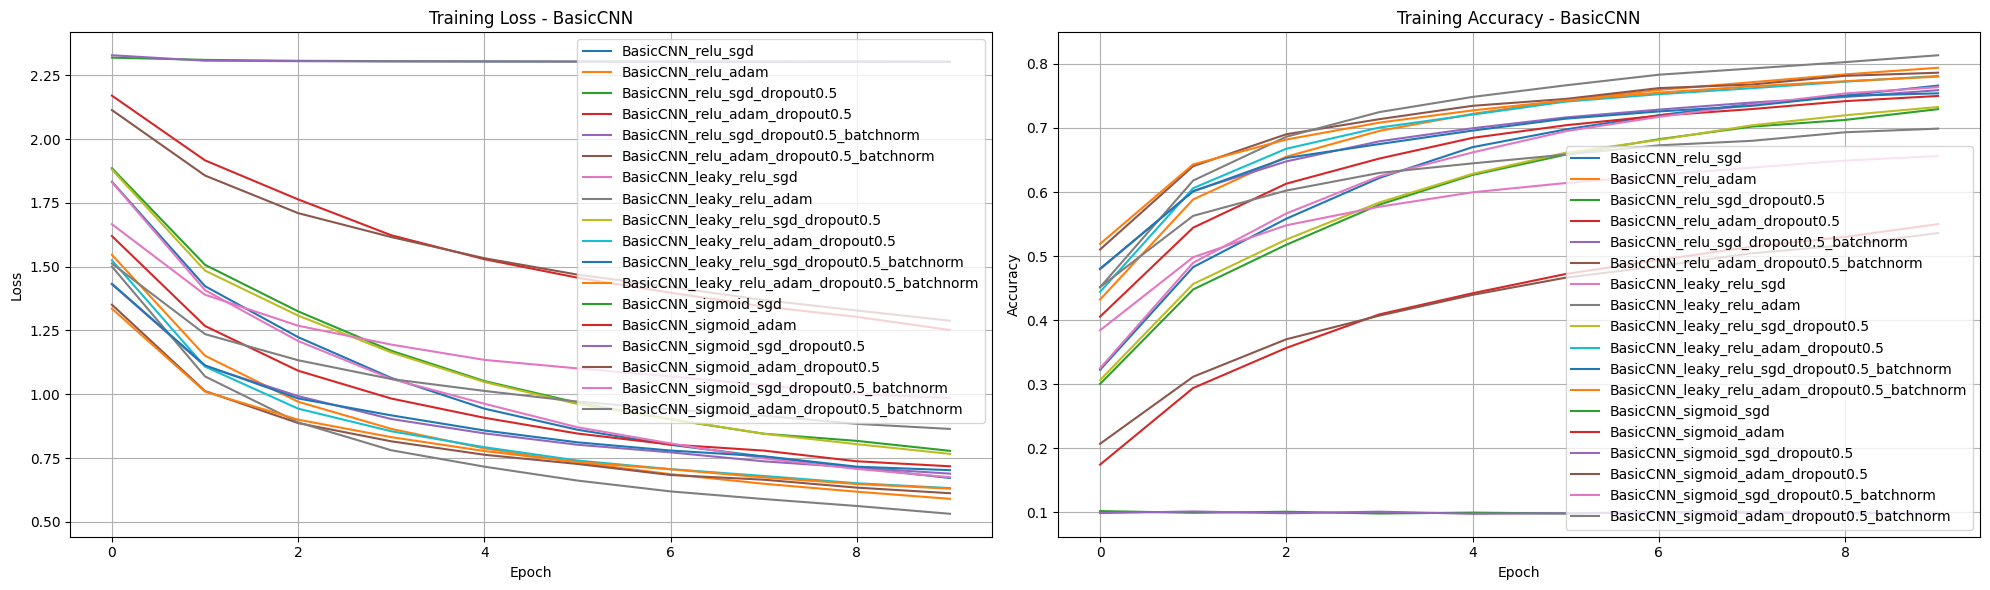

In [10]:
# Parameters
batch_size = 128
epochs = 10

# Load data
train_loader, test_loader = load_cifar10(batch_size)

# Part 1: Hyperparameter search for BasicCNN
print("\n=== Part 1: Hyperparameter Search for BasicCNN ===")
basic_results = hyperparameter_tuning(BasicCNN, train_loader, test_loader, device, epochs=epochs)

# Visualizations for BasicCNN
plot_learning_curves(basic_results, "BasicCNN")
plot_hyperparameter_heatmap(basic_results, "BasicCNN")

### Note: Had to rerun this cell, so results don't match paper exactly ###

In [ ]:
# Part 2: Hyperparameter search for VGG11
print("\n=== Part 2: Hyperparameter Search for VGG11 ===")
vgg_results = hyperparameter_tuning(VGG11, train_loader, test_loader, device, epochs=epochs)

# Visualizations for VGG11
plot_learning_curves(vgg_results, "VGG11")
plot_hyperparameter_heatmap(vgg_results, "VGG11")


=== Part 2: Hyperparameter Search for VGG11 ===

Training model: VGG11_relu_sgd


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3030, Accuracy: 0.1018


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.2980, Accuracy: 0.1078


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0251, Accuracy: 0.2515


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.8000, Accuracy: 0.3336


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.6322, Accuracy: 0.3971


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.5012, Accuracy: 0.4507


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.3966, Accuracy: 0.4912


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.2898, Accuracy: 0.5341


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.1792, Accuracy: 0.5732


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.0828, Accuracy: 0.6136


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.9844, Test Accuracy: 0.6447
Completed VGG11_relu_sgd in 298.69 seconds

Training model: VGG11_relu_adam


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.7144, Accuracy: 0.3503


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.1730, Accuracy: 0.5754


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.8925, Accuracy: 0.6832


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.7273, Accuracy: 0.7468


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.6238, Accuracy: 0.7821


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.5462, Accuracy: 0.8109


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.4876, Accuracy: 0.8323


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.4463, Accuracy: 0.8456


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.4080, Accuracy: 0.8591


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.3718, Accuracy: 0.8715


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.4955, Test Accuracy: 0.8459
Completed VGG11_relu_adam in 298.08 seconds

Training model: VGG11_relu_sgd_dropout0.5


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3028, Accuracy: 0.1000


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3024, Accuracy: 0.1000


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.2163, Accuracy: 0.1548


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.9349, Accuracy: 0.2716


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.7864, Accuracy: 0.3232


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.6630, Accuracy: 0.3748


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.5402, Accuracy: 0.4261


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.4018, Accuracy: 0.4841


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.2988, Accuracy: 0.5275


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.2145, Accuracy: 0.5637


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.0849, Test Accuracy: 0.6084
Completed VGG11_relu_sgd_dropout0.5 in 303.83 seconds

Training model: VGG11_relu_adam_dropout0.5


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.8850, Accuracy: 0.2810


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.3448, Accuracy: 0.5130


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.0357, Accuracy: 0.6353


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.8799, Accuracy: 0.6944


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.7602, Accuracy: 0.7410


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.6747, Accuracy: 0.7722


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.6087, Accuracy: 0.7946


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.5604, Accuracy: 0.8114


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.5236, Accuracy: 0.8247


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.4871, Accuracy: 0.8369


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.5541, Test Accuracy: 0.8169
Completed VGG11_relu_adam_dropout0.5 in 296.21 seconds

Training model: VGG11_relu_sgd_dropout0.5_batchnorm


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.3216, Accuracy: 0.5234


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.8413, Accuracy: 0.7143


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.6701, Accuracy: 0.7767


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.5681, Accuracy: 0.8088


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.4935, Accuracy: 0.8354


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.4443, Accuracy: 0.8532


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.4007, Accuracy: 0.8682


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.3673, Accuracy: 0.8790


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.3371, Accuracy: 0.8907


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.3116, Accuracy: 0.8981


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.3731, Test Accuracy: 0.8731
Completed VGG11_relu_sgd_dropout0.5_batchnorm in 331.91 seconds

Training model: VGG11_relu_adam_dropout0.5_batchnorm


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.3923, Accuracy: 0.4969


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.8743, Accuracy: 0.6997


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.6841, Accuracy: 0.7689


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.5771, Accuracy: 0.8084


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.4982, Accuracy: 0.8342


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.4476, Accuracy: 0.8498


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.3929, Accuracy: 0.8697


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.3573, Accuracy: 0.8805


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.3170, Accuracy: 0.8944


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.2864, Accuracy: 0.9045


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.3739, Test Accuracy: 0.8801
Completed VGG11_relu_adam_dropout0.5_batchnorm in 337.15 seconds

Training model: VGG11_leaky_relu_sgd


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3027, Accuracy: 0.1000


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.2995, Accuracy: 0.1026


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.9882, Accuracy: 0.2615


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.7570, Accuracy: 0.3452


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.5718, Accuracy: 0.4213


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.4358, Accuracy: 0.4787


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.3131, Accuracy: 0.5247


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.1962, Accuracy: 0.5713


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.0847, Accuracy: 0.6136


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.0016, Accuracy: 0.6431


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.9456, Test Accuracy: 0.6648
Completed VGG11_leaky_relu_sgd in 307.39 seconds

Training model: VGG11_leaky_relu_adam


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.8200, Accuracy: 0.3132


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.1646, Accuracy: 0.5796


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.8244, Accuracy: 0.7110


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.6525, Accuracy: 0.7742


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.5533, Accuracy: 0.8115


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.4850, Accuracy: 0.8336


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.4375, Accuracy: 0.8502


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.4009, Accuracy: 0.8634


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.3735, Accuracy: 0.8728


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.3422, Accuracy: 0.8822


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.4021, Test Accuracy: 0.8734
Completed VGG11_leaky_relu_adam in 312.05 seconds

Training model: VGG11_leaky_relu_sgd_dropout0.5


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3028, Accuracy: 0.1006


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3017, Accuracy: 0.1074


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0910, Accuracy: 0.2180


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.8640, Accuracy: 0.2997


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.6820, Accuracy: 0.3734


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.5077, Accuracy: 0.4429


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.3707, Accuracy: 0.4975


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.2787, Accuracy: 0.5351


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.1795, Accuracy: 0.5747


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.0964, Accuracy: 0.6060


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.0145, Test Accuracy: 0.6391
Completed VGG11_leaky_relu_sgd_dropout0.5 in 306.85 seconds

Training model: VGG11_leaky_relu_adam_dropout0.5


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.9809, Accuracy: 0.2442


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.3916, Accuracy: 0.4897


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.0308, Accuracy: 0.6391


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.7920, Accuracy: 0.7288


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.6677, Accuracy: 0.7753


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.5801, Accuracy: 0.8046


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.5172, Accuracy: 0.8254


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.4789, Accuracy: 0.8403


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.4441, Accuracy: 0.8503


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.4133, Accuracy: 0.8608


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.4254, Test Accuracy: 0.8628
Completed VGG11_leaky_relu_adam_dropout0.5 in 312.33 seconds

Training model: VGG11_leaky_relu_sgd_dropout0.5_batchnorm


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.3056, Accuracy: 0.5312


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.8369, Accuracy: 0.7123


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.6765, Accuracy: 0.7726


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.5867, Accuracy: 0.8033


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.5117, Accuracy: 0.8297


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.4673, Accuracy: 0.8459


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.4188, Accuracy: 0.8603


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.3894, Accuracy: 0.8712


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.3612, Accuracy: 0.8815


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.3301, Accuracy: 0.8904


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.3776, Test Accuracy: 0.8728
Completed VGG11_leaky_relu_sgd_dropout0.5_batchnorm in 334.09 seconds

Training model: VGG11_leaky_relu_adam_dropout0.5_batchnorm


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.3951, Accuracy: 0.4913


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.8961, Accuracy: 0.6873


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.6992, Accuracy: 0.7619


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.5970, Accuracy: 0.7978


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.5224, Accuracy: 0.8247


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.4689, Accuracy: 0.8430


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.4289, Accuracy: 0.8573


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.3836, Accuracy: 0.8726


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.3516, Accuracy: 0.8817


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.3225, Accuracy: 0.8921


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.3747, Test Accuracy: 0.8753
Completed VGG11_leaky_relu_adam_dropout0.5_batchnorm in 340.85 seconds

Training model: VGG11_sigmoid_sgd


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3193, Accuracy: 0.1000


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3078, Accuracy: 0.1000


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3050, Accuracy: 0.0998


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3039, Accuracy: 0.0984


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3034, Accuracy: 0.0993


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3031, Accuracy: 0.0987


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3029, Accuracy: 0.0988


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3028, Accuracy: 0.0982


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3028, Accuracy: 0.0996


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3027, Accuracy: 0.0986


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 2.3027, Test Accuracy: 0.1000
Completed VGG11_sigmoid_sgd in 306.89 seconds

Training model: VGG11_sigmoid_adam


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3047, Accuracy: 0.0997


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3036, Accuracy: 0.1000


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3035, Accuracy: 0.1000


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3034, Accuracy: 0.1000


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3033, Accuracy: 0.1000


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3033, Accuracy: 0.1000


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3032, Accuracy: 0.1000


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3033, Accuracy: 0.1000


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3033, Accuracy: 0.1000


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3033, Accuracy: 0.1000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 2.3033, Test Accuracy: 0.1000
Completed VGG11_sigmoid_adam in 311.84 seconds

Training model: VGG11_sigmoid_sgd_dropout0.5


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3580, Accuracy: 0.1023


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3448, Accuracy: 0.0999


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3431, Accuracy: 0.0997


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3387, Accuracy: 0.1002


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3381, Accuracy: 0.1001


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3371, Accuracy: 0.1009


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3373, Accuracy: 0.0994


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3354, Accuracy: 0.0987


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3369, Accuracy: 0.1006


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3365, Accuracy: 0.0996


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 2.3032, Test Accuracy: 0.1000
Completed VGG11_sigmoid_sgd_dropout0.5 in 305.73 seconds

Training model: VGG11_sigmoid_adam_dropout0.5


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3429, Accuracy: 0.0986


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3415, Accuracy: 0.1004


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3402, Accuracy: 0.1008


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3408, Accuracy: 0.1008


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3404, Accuracy: 0.0986


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3393, Accuracy: 0.1012


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3399, Accuracy: 0.1034


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3397, Accuracy: 0.1022


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3416, Accuracy: 0.0981


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3408, Accuracy: 0.0992


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 2.3053, Test Accuracy: 0.1000
Completed VGG11_sigmoid_adam_dropout0.5 in 310.87 seconds

Training model: VGG11_sigmoid_sgd_dropout0.5_batchnorm


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.2205, Accuracy: 0.1739


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.1151, Accuracy: 0.2365


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0652, Accuracy: 0.2816


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0281, Accuracy: 0.3178


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.9957, Accuracy: 0.3525


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9640, Accuracy: 0.3854


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9378, Accuracy: 0.4099


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9110, Accuracy: 0.4363


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.8913, Accuracy: 0.4533


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.8691, Accuracy: 0.4770


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.9179, Test Accuracy: 0.4885
Completed VGG11_sigmoid_sgd_dropout0.5_batchnorm in 334.13 seconds

Training model: VGG11_sigmoid_adam_dropout0.5_batchnorm


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1916, Accuracy: 0.1688


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0092, Accuracy: 0.3025


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.8626, Accuracy: 0.4396


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.7654, Accuracy: 0.5230


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.6954, Accuracy: 0.5775


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.6458, Accuracy: 0.6166


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.6048, Accuracy: 0.6452


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.5736, Accuracy: 0.6726


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.5457, Accuracy: 0.6932


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.5238, Accuracy: 0.7105


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.9781, Test Accuracy: 0.3544
Completed VGG11_sigmoid_adam_dropout0.5_batchnorm in 342.15 seconds


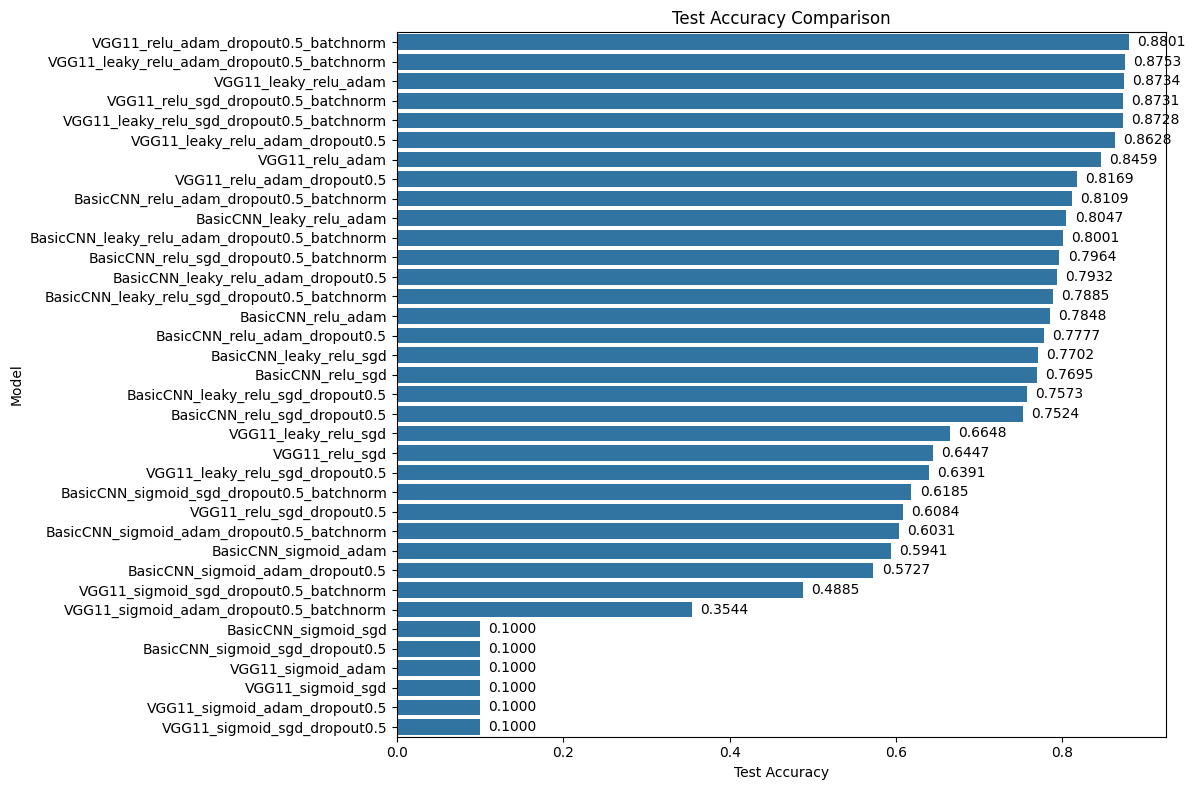

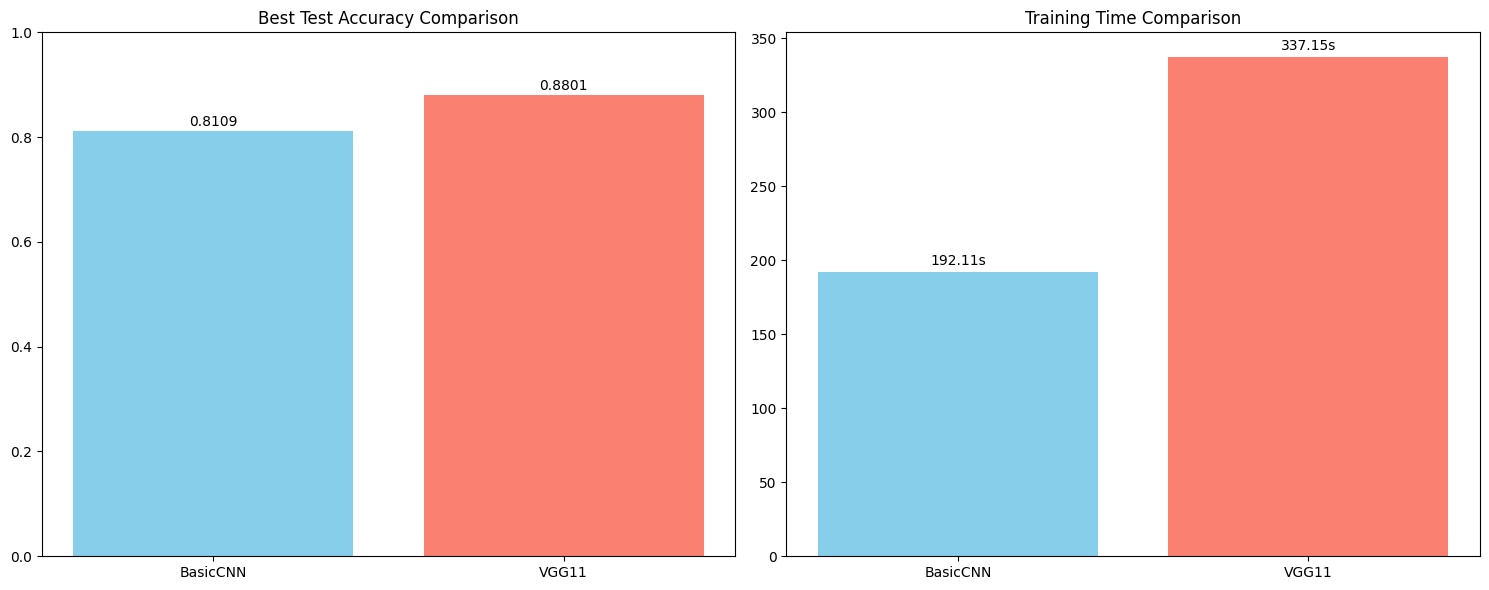

Best Models Details:

BasicCNN:
  Configuration: BasicCNN_relu_adam_dropout0.5_batchnorm
  Test Accuracy: 0.8109
  Training Time: 192.11 seconds

VGG11:
  Configuration: VGG11_relu_adam_dropout0.5_batchnorm
  Test Accuracy: 0.8801
  Training Time: 337.15 seconds


In [ ]:
# Combined results
all_results = basic_results + vgg_results

# Overall comparisons
plot_test_accuracy_comparison(all_results)
plot_training_time_comparison(all_results)
plot_model_comparison(all_results)